In [607]:
from bs4 import BeautifulSoup
import requests

import unicodedata
from csv import writer
import re

import pandas as pd
import numpy as np

import json


#spark session
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F


import os
import re 

#folium
import geopandas as gpd
import re
import folium

In [608]:
# Create a spark session

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

#read in the parquet
domain = spark.read.parquet('../data/raw/domain-website-data')


In [609]:
#drop NSW
domain = domain.filter(F.col('state') == 'VIC')

#drop column with too many missing values
domain = domain.drop('land_size','land_unit','is_rural','is_retirement','url').toPandas()

#filter property type, remove 'cat spcae' and 'Acreage / Semi-Rural'
selected_property_type = ['Apartment / Unit / Flat', 'Studio', 'Townhouse',
       'House', 'New House & Land', 'Semi-Detached', 'Villa', 'Terrace',
       'Acreage / Semi-Rural', 'New Apartments / Off the Plan', 'Duplex',
       'Unknown', 'Farm', 'Penthouse', 'Rural']

domain= domain.loc[domain['property_type'].isin(selected_property_type)]

In [610]:
#remove instance with 'carpark' in street name
def carpark_flag(s):
    pattern = re.compile('carpark|CP|car park|carspace')
    match = re.match(pattern,s)
    #o for non carpark, 1 for carpark
    if match is None:
        return 0
    else:
        return 1

In [611]:
def get_rent(s):
    pattern = re.compile('^( )*([0-9]*)( )*')
    num = re.sub('(,)?', '',s)
    num = re.sub('[^0-9]+', ' ',num)
    match = re.match(pattern,num)[0].replace(" ", "")

    if match !='':
        return match
    else:
        return 0

In [612]:
domain['street'] = domain['street'].str.lower()
domain['carpark_flag'] = [carpark_flag(i) for i in domain['street']]
domain['price_rent'] = [float(get_rent(i)) for i in domain['price']]
domain['coordinate'] = domain[['longitude','latitude']].values.tolist()

In [613]:
# exclude car park instance
domain = domain[(domain.carpark_flag != 1) & (domain.price_rent > 40)]

# remove property without bathroom or bedroom
domain = domain[(domain.bedrooms != 0) & (domain.bathrooms != 0)]

# remove property greater than 4000 pw
domain = domain[(domain.price_rent < 4000)]



In [614]:
'''

remove postcode with less than 10 property

'''
domain_spk = spark.createDataFrame(domain)

#417 postcode obtained
count_agg = domain_spk.groupby('postcode').count()\
            .withColumnRenamed("postcode","postcode_1")\
            .withColumnRenamed("count","postcode_property_count")
domain_spk = domain_spk.join(count_agg,domain_spk.postcode == count_agg.postcode_1,"inner").drop('postcode_1')

#remove postcode with less than 10 property
domain_spk = domain_spk.filter((F.col('postcode_property_count') > 15))

# 231 postcode remains
domain_spk.groupby('postcode').count().count()

211

count    13830.000000
mean       119.221258
std        107.623925
min         16.000000
25%         53.000000
50%         90.000000
75%        141.000000
max        550.000000
Name: postcode_property_count, dtype: float64

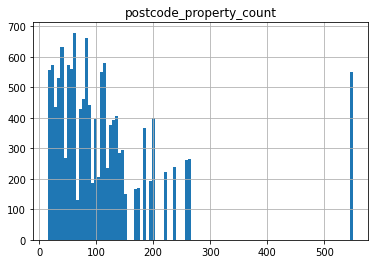

In [615]:
# see where properties are distributed
domain = domain_spk.toPandas()
domain.hist(column='postcode_property_count',bins=100)
domain['postcode_property_count'].describe()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The price_rent skewness is 4.47


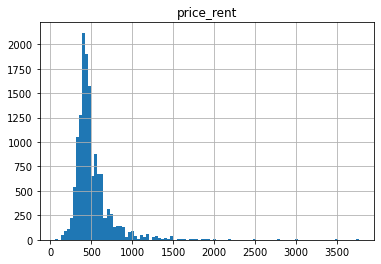

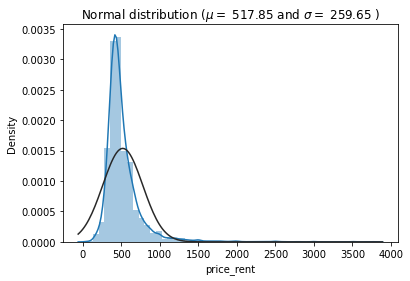

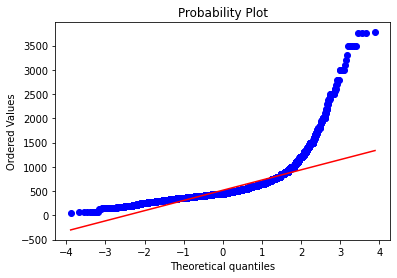

In [616]:
#plot price against normal distribution to see skewness
import seaborn as sns
from scipy import stats

#plot rental price to see outliers
domain.hist(column='price_rent',bins=100)

#info about rental price
domain['price_rent'].describe()

def skew_distribution(data, col='price_rent'):
    fig, ax1 = plt.subplots()
    sns.distplot(data[col], ax=ax1, fit=stats.norm)
    (mu, sigma) = stats.norm.fit(data[col])
    ax1.set(title='Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma))

    fig, ax2 = plt.subplots()
    stats.probplot(data[col], plot=plt)

    print('The {} skewness is {:.2f}'.format(col, stats.skew(data[col])))
    
skew_distribution(domain, col='price_rent')


In [617]:
#find postcode that are of interest
postcode_list = list(domain['postcode'].unique())

#filter postcode based on properties
postcode_df = gpd.read_file("../data/raw/POSTCODE/POSTCODE_POLYGON.shp")
postcode_df['POSTCODE'] = pd.to_numeric(postcode_df['POSTCODE'])
postcode_df= postcode_df.loc[postcode_df['POSTCODE'].isin(postcode_list)].reset_index()
postcode_df = postcode_df.drop(columns = 'index')

#add centroid
postcode_df['centroid'] = postcode_df['geometry'].centroid

#find CBD centroid
CBD_centroid = postcode_df.loc[postcode_df['POSTCODE'] == 3000]['centroid']
CBD_centroid =[CBD_centroid.values.x[0],CBD_centroid.values.y[0]]

#add x,y of centroid
postcode_df['centroid_x'] = [postcode_df['centroid'].values.x[i] for i in range(len(postcode_df))]
postcode_df['centroid_y'] = [postcode_df['centroid'].values.y[i] for i in range(len(postcode_df))]

/var/folders/7v/v1gh4ksn641cv86zx_w_yd840000gp/T/ipykernel_70524/144973203.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcode_df['centroid'] = postcode_df['geometry'].centroid


In [623]:
import openrouteservice

client = openrouteservice.Client(key='5b3ce3597851110001cf6248f596dd33da864705b4185662da1dd01d')

In [639]:
#regional vic: 3211 to 3232, 3235, 3240, 3328, 3330 to 3333, 3340 and 3342
#metro mel: 3000-3207
metro_list = [i for i in range(3000,3208)]
regional_distinct = [3235, 3240, 3328, 3330,3333, 3340,3342]
regional_list = [i for i in range(3211,3233)] + regional_distinct

#remove postcode not appears in properties postcode
metro_list = list(set(metro_list) & set(postcode_list))
regional_list = list(set(regional_list) & set(postcode_list))

In [666]:
len(regional_list)

13

In [678]:
def regional_postcode_centroid(postcode):
    lat = domain[domain['postcode'] == postcode]['latitude'].mean()
    lon = domain[domain['postcode'] == postcode]['longitude'].mean()
    return [lon,lat]


def calcualte_avg_to_CBD(postcode_list): 
    dic = {'postcode':[],'distance':[], 'duration':[]}
    for postcode in postcode_list:
        avg_coor = regional_postcode_centroid(postcode)
        route = client.directions(
                coordinates= [avg_coor, CBD_centroid],
                profile='driving-car',
                format='geojson')
        time.sleep(5)
        distance = route['features'][0]['properties']['summary']['distance']
        duration = route['features'][0]['properties']['summary']['duration']
        dic['postcode'].append(postcode)
        dic['distance'].append(distance)
        dic['duration'].append(duration)
    return dic

In [679]:
import time
def calcualte_centroid_to_CBD(postcode_list):
    dic = {'postcode':[],'distance':[], 'duration':[]}
    for postcode in postcode_list:
        x = postcode_df[postcode_df['POSTCODE'] == postcode]['centroid'].values.x[0]
        y = postcode_df[postcode_df['POSTCODE'] == postcode]['centroid'].values.y[0]
        route = client.directions(
                coordinates= [[x,y], CBD_centroid],
                profile='driving-car',
                format='geojson')
        time.sleep(5)
        distance = route['features'][0]['properties']['summary']['distance']
        duration = route['features'][0]['properties']['summary']['duration']
        dic['postcode'].append(postcode)
        dic['distance'].append(distance)
        dic['duration'].append(duration)
    return dic

In [680]:

calcualte_avg_to_CBD(metro_list)

Timeout: 